# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

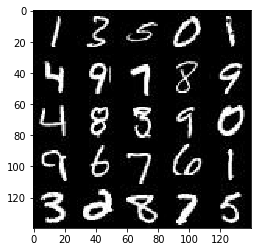

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

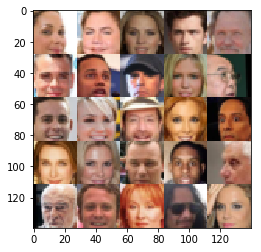

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    image_input = tf.placeholder(tf.float32, name='input', shape=(None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, name='z_input', shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return image_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        alpha=0.2
        
        
        kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)
        
        # Input layer is 28x28x3
        conv = tf.layers.conv2d(images, 64, 1, strides=1, padding='same', kernel_initializer=kernel_initializer)
        conv = tf.maximum(alpha * conv, conv)
        # 28x28x64
        
         
        conv = tf.layers.conv2d(images, 128, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        conv = tf.maximum(alpha * conv, conv)
        # 14x14x64
        
        conv = tf.layers.conv2d(conv, 256, 5, strides=2, padding='same', kernel_initializer=kernel_initializer)
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        # 7x7x128
        
        # Flatten it
        flat = tf.reshape(conv, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse= not is_train):
        
        initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)

        z = tf.layers.dense(inputs=z, units=3*3*512, kernel_initializer=initializer)
        # Reshape it to start the convolutional stack
        z = tf.reshape(z, (-1, 3, 3, 512))
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.nn.relu(z)
        # 3x3x512 now
        
        z = tf.layers.conv2d_transpose(z, 256, 3, strides=2, padding='valid', kernel_initializer=initializer)
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.nn.relu(z)
        # 7x7x256 now
        

        z = tf.layers.conv2d_transpose(z, 128, 5, strides=2, padding='same', kernel_initializer=initializer)
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.nn.relu(z)
        # 14x14x128 now
        
        z = tf.layers.conv2d_transpose(z, 64, 5, strides=2, padding='same', kernel_initializer=initializer)
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.nn.relu(z)
        # 28x28x64 now

        # Output layer
        logits = tf.layers.conv2d_transpose(z, out_channel_dim, 1, strides=1, padding='same', kernel_initializer=initializer)
        # 28x28x3 now

        out = tf.tanh(logits)

        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [15]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [16]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    d_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [18]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    print('training')
    
    channels = 3
    if data_image_mode == "L":
        channels = 1
        
        
    input_real, input_z, lr = model_inputs(28,28,channels, z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, channels)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                batch_images *= 2

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % 100 == 0:
                    
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

    print('done')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

training


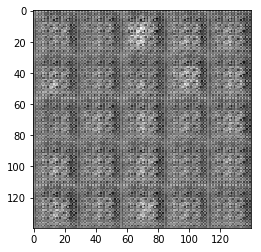

Epoch 1/2... Discriminator Loss: 1.3713... Generator Loss: 5.8472


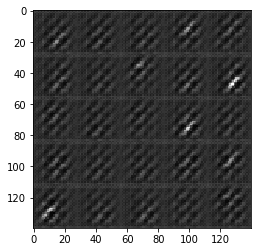

Epoch 1/2... Discriminator Loss: 0.4888... Generator Loss: 2.3649


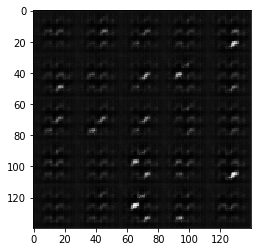

Epoch 1/2... Discriminator Loss: 1.5451... Generator Loss: 0.4694


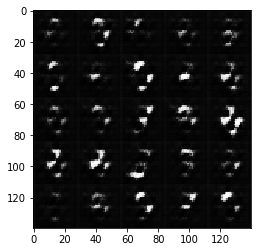

Epoch 1/2... Discriminator Loss: 1.1679... Generator Loss: 4.6998


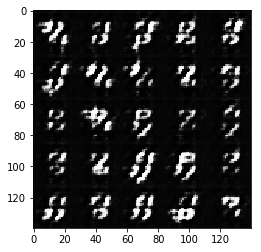

Epoch 1/2... Discriminator Loss: 0.6168... Generator Loss: 2.2129


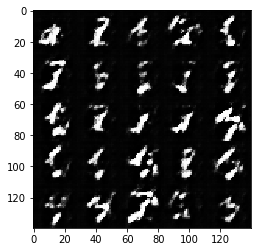

Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 1.7603


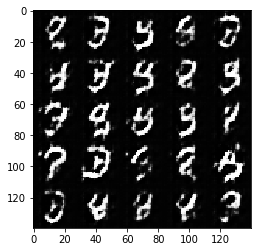

Epoch 1/2... Discriminator Loss: 0.7180... Generator Loss: 1.7815


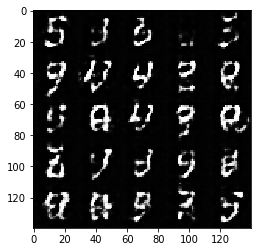

Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 1.7569


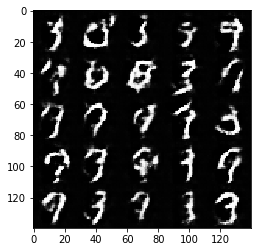

Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 1.2558


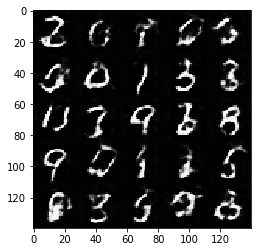

Epoch 1/2... Discriminator Loss: 1.0745... Generator Loss: 1.0369


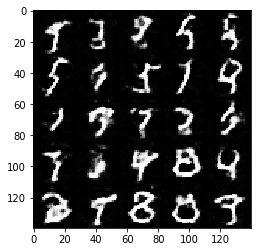

Epoch 1/2... Discriminator Loss: 1.2669... Generator Loss: 0.8762


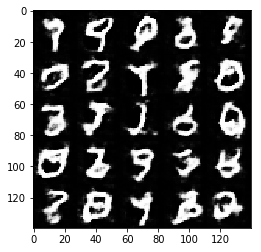

Epoch 1/2... Discriminator Loss: 1.1691... Generator Loss: 1.0360


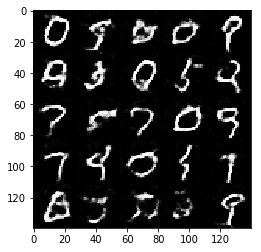

Epoch 1/2... Discriminator Loss: 1.2962... Generator Loss: 0.8932


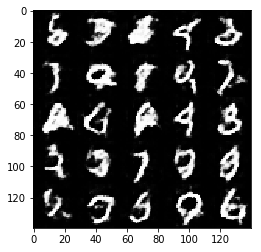

Epoch 1/2... Discriminator Loss: 1.2514... Generator Loss: 0.7931


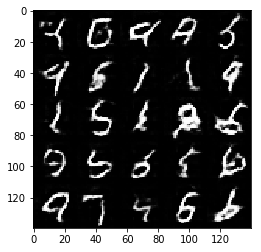

Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.8219


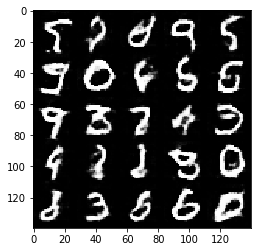

Epoch 1/2... Discriminator Loss: 1.1299... Generator Loss: 0.8019


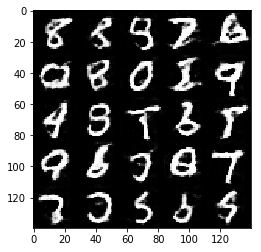

Epoch 1/2... Discriminator Loss: 1.1099... Generator Loss: 1.1968


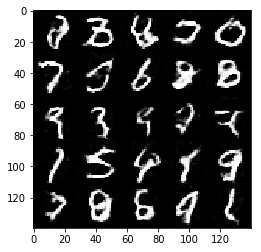

Epoch 1/2... Discriminator Loss: 1.3638... Generator Loss: 0.5834


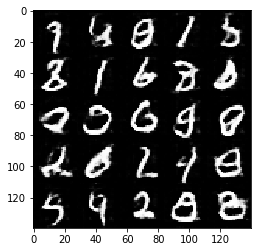

Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 1.4332


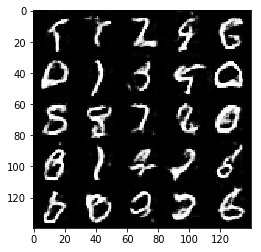

Epoch 2/2... Discriminator Loss: 1.2143... Generator Loss: 0.9344


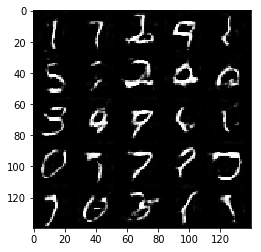

Epoch 2/2... Discriminator Loss: 1.2618... Generator Loss: 0.6693


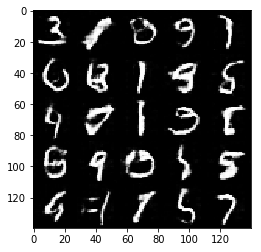

Epoch 2/2... Discriminator Loss: 1.2157... Generator Loss: 0.8655


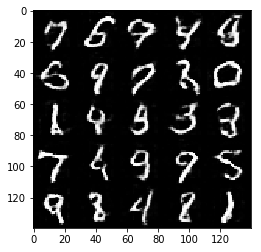

Epoch 2/2... Discriminator Loss: 1.3028... Generator Loss: 0.6812


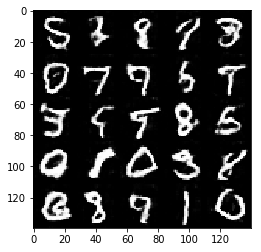

Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.7456


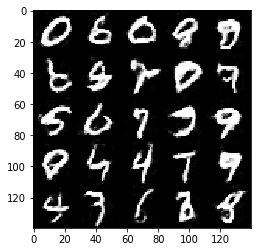

Epoch 2/2... Discriminator Loss: 1.4318... Generator Loss: 0.5608


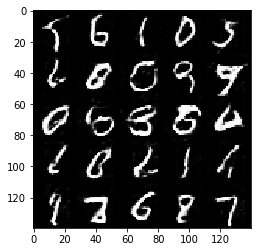

Epoch 2/2... Discriminator Loss: 1.4620... Generator Loss: 0.6212


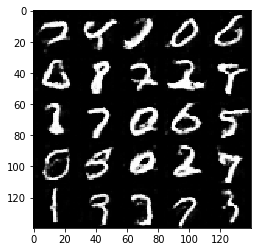

Epoch 2/2... Discriminator Loss: 1.2413... Generator Loss: 1.0442


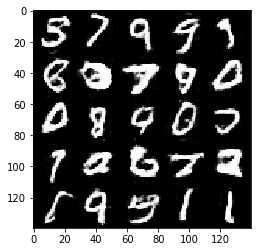

Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.8149


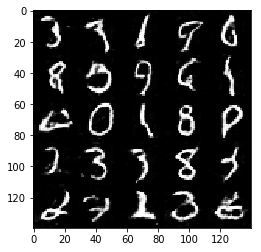

Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 1.0174


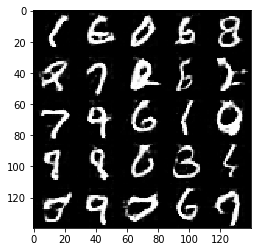

Epoch 2/2... Discriminator Loss: 1.2374... Generator Loss: 1.0820


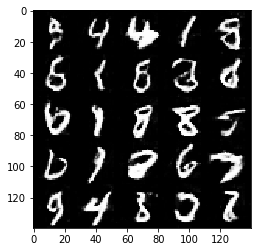

Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 1.0009


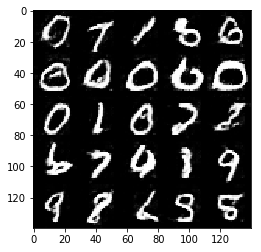

Epoch 2/2... Discriminator Loss: 1.1798... Generator Loss: 0.9206


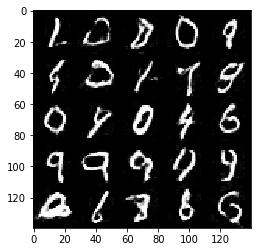

Epoch 2/2... Discriminator Loss: 1.3234... Generator Loss: 0.6295


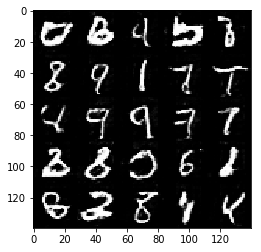

Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 1.2037


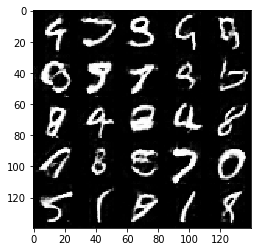

Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.5936


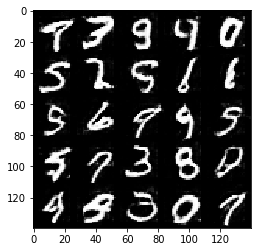

Epoch 2/2... Discriminator Loss: 1.2221... Generator Loss: 0.8380


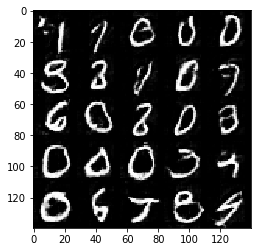

Epoch 2/2... Discriminator Loss: 1.2581... Generator Loss: 1.1368
done


In [19]:
batch_size = 32
z_dim = 100
learning_rate =0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

training


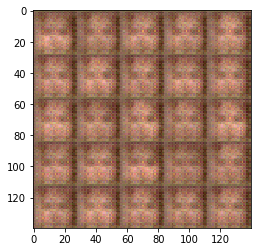

Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8287


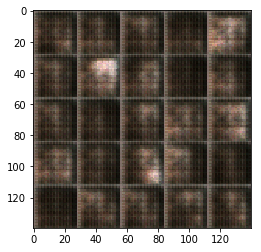

Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.1892


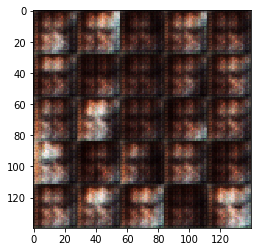

Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.3746


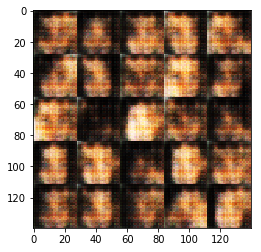

Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 1.2647


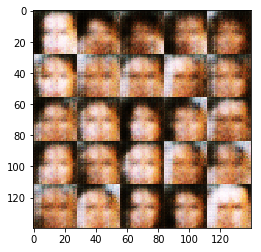

Epoch 1/1... Discriminator Loss: 1.7131... Generator Loss: 0.6648


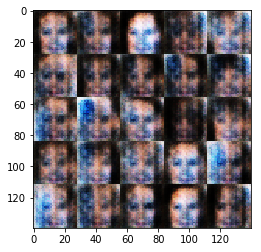

Epoch 1/1... Discriminator Loss: 1.6318... Generator Loss: 0.8256


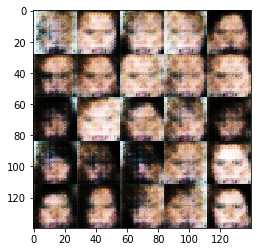

Epoch 1/1... Discriminator Loss: 0.8559... Generator Loss: 1.3666


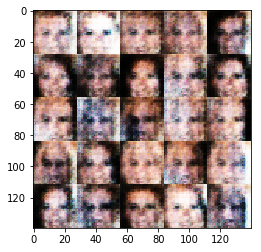

Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.8749


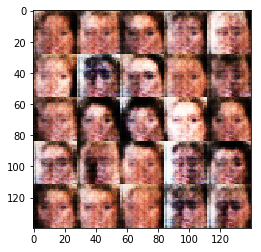

Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 1.2395


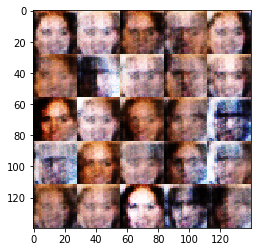

Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.9792


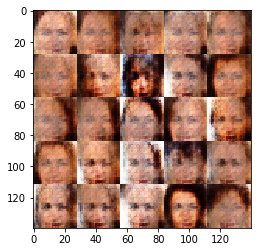

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 1.1024


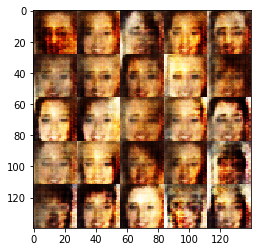

Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 1.0337


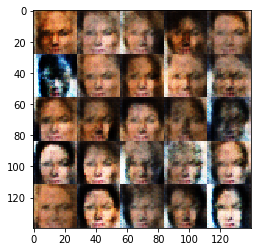

Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.8992


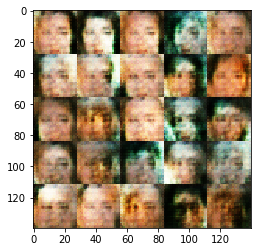

Epoch 1/1... Discriminator Loss: 1.7849... Generator Loss: 0.5975


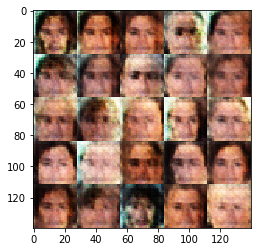

Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.9668


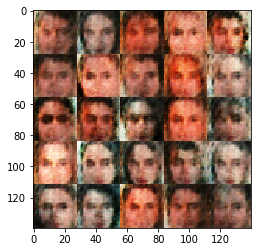

Epoch 1/1... Discriminator Loss: 1.3418... Generator Loss: 0.8963


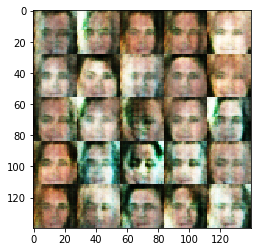

Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 1.0090


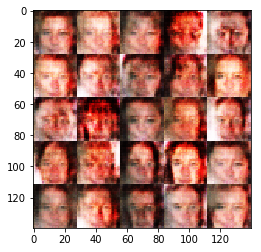

Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 1.0542


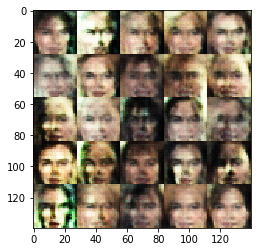

Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.9614


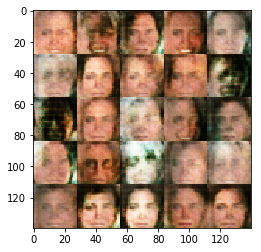

Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 1.1849


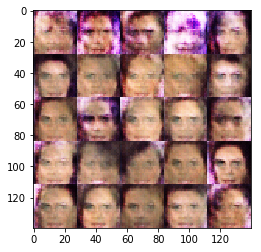

Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.2530


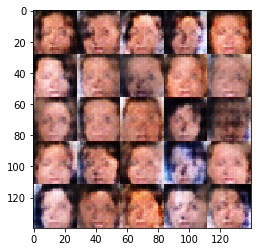

Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.5764


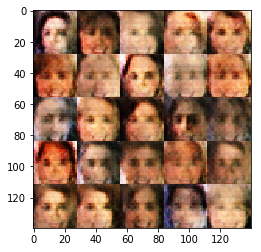

Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 1.0638


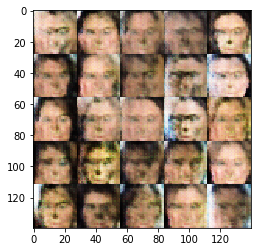

Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8900


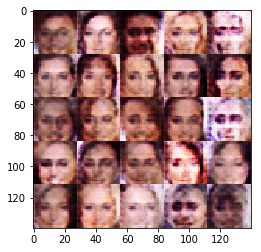

Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.8984


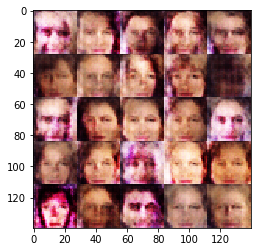

Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 1.2147


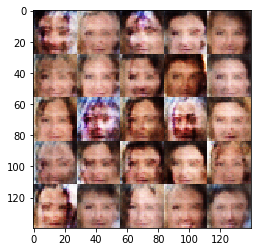

Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.9385


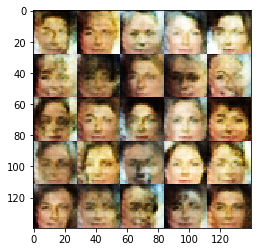

Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.1946


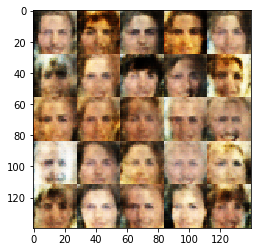

Epoch 1/1... Discriminator Loss: 1.2939... Generator Loss: 1.2851


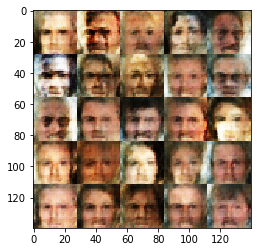

Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7830


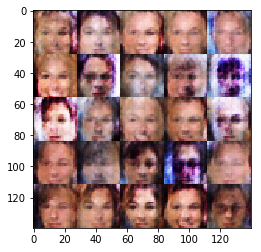

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 1.1513


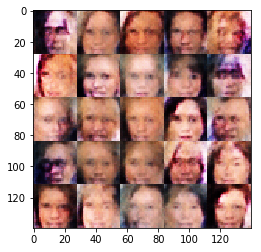

Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.7615


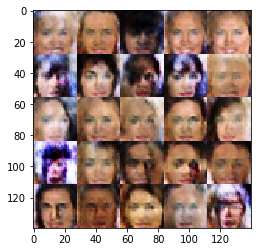

Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 1.0375


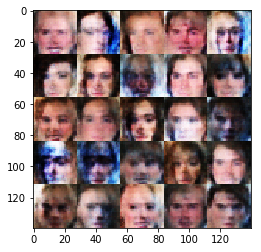

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8054


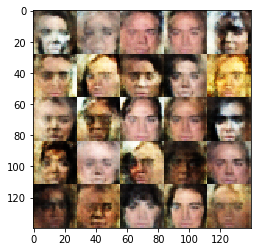

Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.7340


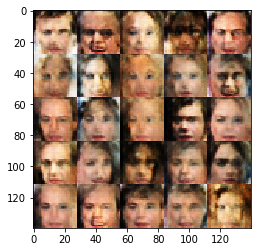

Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 1.0168


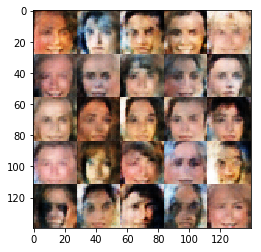

Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 1.1179


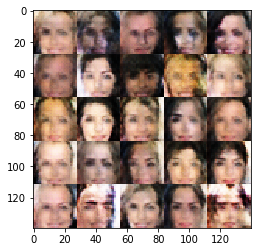

Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.9384


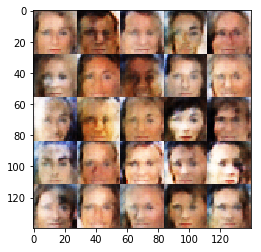

Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.9494


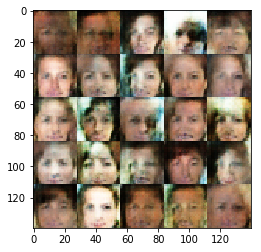

Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.7517


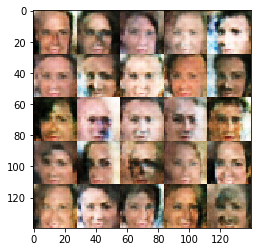

Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7917


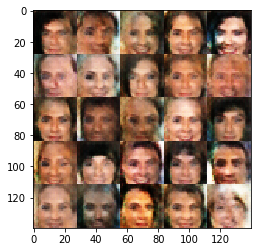

Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8892


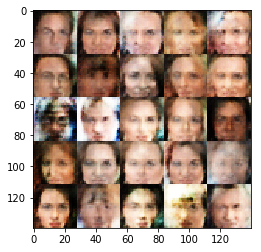

Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.7216


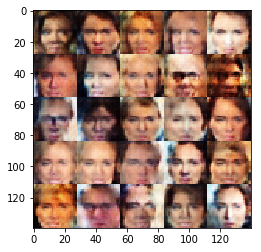

Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.8956


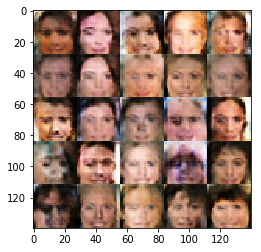

Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 0.9246


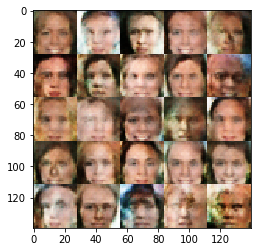

Epoch 1/1... Discriminator Loss: 1.1113... Generator Loss: 1.0616


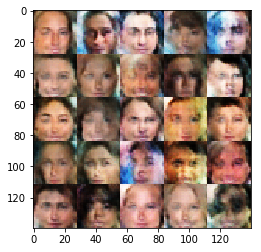

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.9211


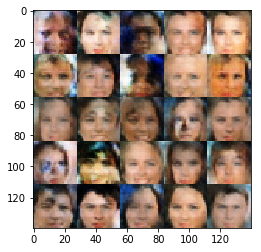

Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.8905


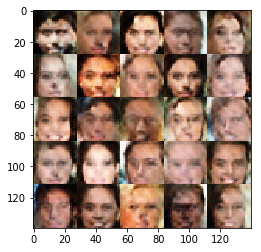

Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.6607


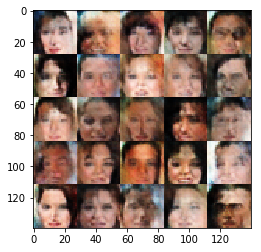

Epoch 1/1... Discriminator Loss: 1.3036... Generator Loss: 0.8586


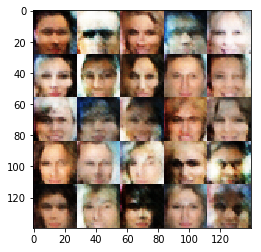

Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.9374


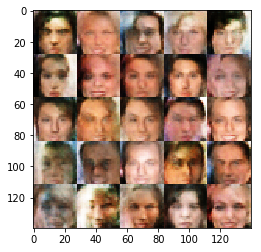

Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.0089


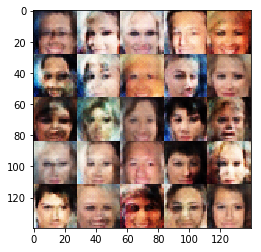

Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.9764


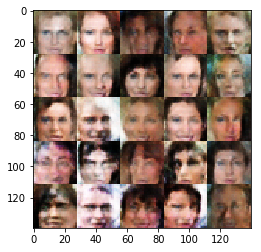

Epoch 1/1... Discriminator Loss: 1.3274... Generator Loss: 0.8471


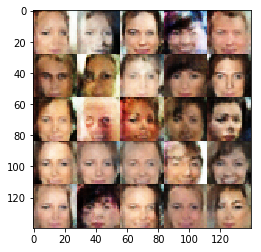

Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 1.1501


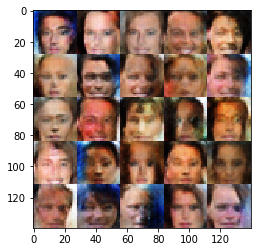

Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.8046


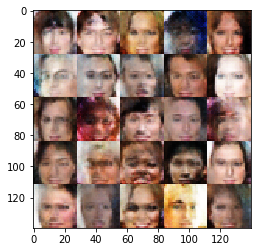

Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.9646


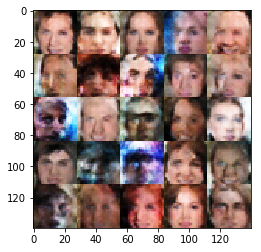

Epoch 1/1... Discriminator Loss: 1.3136... Generator Loss: 1.0049


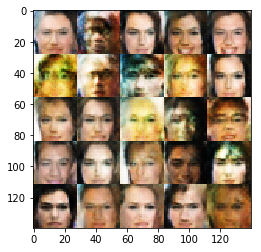

Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.9537


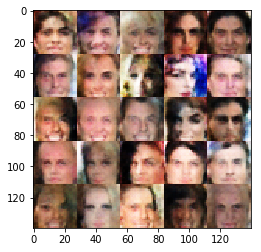

Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 0.8508


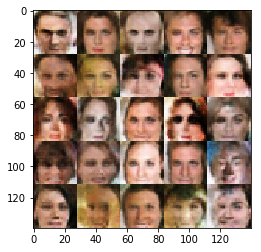

Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6543


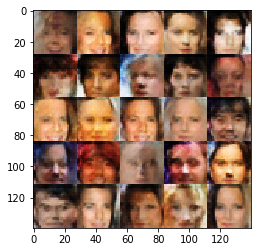

Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.6517


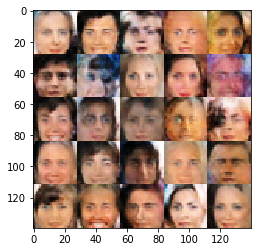

Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.9503
done


In [20]:
batch_size = 32
z_dim = 100
learning_rate =0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.